# Introduction
- People with pulmonary disease often have a high opacity, which makes segmentation of the lung from chest X-rays more difficult.
- In this study, I propose a methodology to improve the performance of the U-NET structure so that it is able to extract the features and spatial characteristics of the X-ray images of the chest region, in addition to the ability to find a link between the left and right parts of the chest region, which helps the neural network to locate the lungs within the X-ray images ( segmentation).
- Since the variational autoencoder is used for generation, we can use it to extract the most important information in the x-ray images, such as what we mentioned, the relationship between the left and right parts of the chest region.
- Therefore, I proposed integrating the U-NET structure with the variational autoencoder structure in order to reach a neural network structure capable of segmentation for people with lung diseases.
- To ensure the accuracy of the study, the neural network was trained on medical chest x-rays of people with lung opacity, and then the model was tested on chest x-rays of people with COVID-19.
- The results were as follows: The model was able to train it on chest x-rays of people with lung opacity:
accuracy: 0.9829 - precision: 0.9939 - recall: 0.9606.
After completing the training, the model was tested on chest X-rays of people infected with COVID-19, and the results obtained were accuracy: 0.9789 - precision: 0.9902 - recall: 0.9650

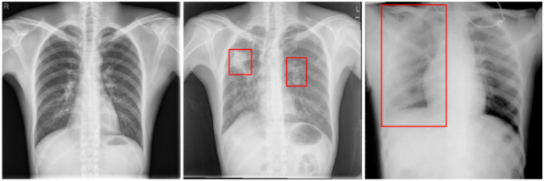

**The previous image shows several samples of X-ray images of a healthy person, a person with medium opacity, and a person with high opacity.**

# Download Dataset

# Import Packages

In [ ]:
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pathlib
import cv2

# Read dataset images

In [ ]:
class Dataset:
  def __init__(self, dataset_image_path, 
               dataset_mask_path):
    self.dataset_image_path = dataset_image_path
    self.dataset_mask_path = dataset_mask_path
  def get_paths(self):
    self.images_dataset = list(pathlib.Path(self.dataset_image_path).glob("*.*"))
    self.masks_dataset = list(pathlib.Path(self.dataset_mask_path).glob("*.*"))
  def images_read(self, type_read):
    images = []
    if type_read == 'images':
      list_data = self.images_dataset
    else:
      list_data = self.masks_dataset
    for image in list_data:
      if type_read == 'images':
        img = cv2.imread(str(image))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      else:
        img = cv2.imread(str(image), 0)
      img = cv2.resize(img, (128, 128))
      img = img/255
      images.append(img)
    images = np.array(images)
    if type_read == 'images':
      self.images_data = images
    else:
      self.masks_data = images

In [ ]:
dataset = Dataset("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/images",
                  "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/Lung_Opacity/masks")
dataset.get_paths()

In [ ]:
len(dataset.images_dataset), len(dataset.masks_dataset)

In [ ]:
dataset.images_read('images')
dataset.images_read('masks')

In [ ]:
dataset.images_data.shape, dataset.masks_data.shape

In [ ]:
test_dataset = Dataset("/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images",
                  "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/masks")
test_dataset.get_paths()
test_dataset.images_read('images')
test_dataset.images_read('masks')

In [ ]:
test_dataset.images_data.shape, test_dataset.masks_data.shape

In [ ]:
def show_images_with_masks(figure_size, masks, images, alpha):
  plt.figure(figsize = figure_size)
  for i in range(64):
    plt.subplot(8, 8, (i + 1))
    plt.imshow(images[i])
    plt.imshow(masks[i], alpha = alpha, cmap = 'jet')
  plt.legend()

# Reviewing samples of images of people with Lung_Opacity

In [ ]:
show_images_with_masks((20, 20), dataset.masks_data, dataset.images_data, 0.2)

# Reviewing samples of images of people with COVID-19

In [ ]:
show_images_with_masks((20, 20), test_dataset.masks_data, test_dataset.images_data, 0.2)

# Proposed Model

In [ ]:
def sampling(args):
  z_mean, z_log_v = args
  batch = tf.shape(z_mean)[0]
  dim = tf.shape(z_mean)[1]
  e = K.random_normal(shape = (batch, dim))
  return z_mean + tf.exp(0.5*z_log_v)*e

In [ ]:
class U_NET_VAE:
  def __init__(self, filters, kernel_size,
               dropout, latent_space):
    self.filters = filters
    self.kernel_size = kernel_size
    self.dropout = dropout
    self.latent_space = latent_space
  def convolution(self, input, filters, encoder, activation):
    x = tf.keras.layers.Conv2D(filters, self.kernel_size, padding = 'same')(input)
    if encoder == True:
      x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    x = tf.keras.layers.Conv2D(filters, self.kernel_size, padding= 'same')(x)
    if encoder == True:
      x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(activation)(x)
    return x
  def encoder(self, input, filters):
    convolution = self.convolution(input, filters, True, 'LeakyReLU')
    downSample = tf.keras.layers.MaxPooling2D()(convolution)
    return convolution, downSample
  def decoder(self, input, skip_connection, filters):
    upSampling = tf.keras.layers.Conv2DTranspose(filters, self.kernel_size, strides = 2, padding = 'same',
                                                activation = 'relu')(input)
    attention = tf.keras.layers.concatenate([skip_connection, upSampling])
    convolution = self.convolution(attention, filters, False, 'relu')
    return convolution
  def U_net(self):
    input = tf.keras.layers.Input(shape = (128, 128, 3))
    skip, encoder1 = self.encoder(input, self.filters)
    skip_2, encoder2 = self.encoder(encoder1, self.filters*2)
    skip_3, encoder3 = self.encoder(encoder2, self.filters*4)
    skip_4, encoder4 = self.encoder(encoder3, self.filters*8)
    skip_5, encoder5 = self.encoder(encoder4, self.filters*16)
    conv = self.convolution(encoder5, self.filters*16, True, 'LeakyReLU')
    shape = K.int_shape(conv)
    x = tf.keras.layers.GlobalAveragePooling2D()(conv)
    z_mean = tf.keras.layers.Dense(self.latent_space, name = "z_mean")(x)
    z_log_v = tf.keras.layers.Dense(self.latent_space, name = "z_log_v")(x)
    z = tf.keras.layers.Lambda(sampling, 
                               output_shape = (self.latent_space,), name = "z")([z_mean, z_log_v])
    decoder_z = tf.keras.layers.Dense(shape[1]*shape[2]*shape[3])(z)
    decoder_z = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(decoder_z)
    conv = self.convolution(decoder_z, self.filters*16, False, 'relu')
    decoder_mask_1 = self.decoder(conv, skip_5, self.filters*16)
    decoder_mask_2 = self.decoder(decoder_mask_1, skip_4, self.filters*8)
    decoder_mask_3 = self.decoder(decoder_mask_2, skip_3, self.filters*4)
    decoder_mask_4 = self.decoder(decoder_mask_3, skip_2, self.filters*2)
    decoder_mask_5 = self.decoder(decoder_mask_4, skip, self.filters)
    output_mask = tf.keras.layers.Conv2DTranspose(1, 1, 
                                             padding = 'same', activation = 'sigmoid',
                                             name = 'mask')(decoder_mask_5)
    mask_input = tf.keras.layers.Input(shape = (128, 128, 1))
    m = tf.keras.models.Model(
        inputs = [input, mask_input], 
        outputs = [output_mask]
    )
    return m, input, mask_input, output_mask, z_log_v, z_mean

In [ ]:
u_net = U_NET_VAE(filters = 32, kernel_size = 3,
               dropout = 0.2, latent_space = 128)

In [ ]:
m, input, mask_input, output_mask, z_log_v, z_mean = u_net.U_net()

In [ ]:
m.summary()

In [ ]:
tf.keras.utils.plot_model(m, show_shapes = True)

In [ ]:
re_loss_mask = tf.keras.losses.binary_focal_crossentropy(output_mask, mask_input)
re_loss_mask = tf.reduce_mean(re_loss_mask)
re_loss_mask = re_loss_mask*128*128

In [ ]:
kl_loss = 1 + z_log_v - tf.exp(z_log_v) - tf.square(z_mean)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss = kl_loss*(-0.5)

In [ ]:
all_loss = kl_loss + re_loss_mask

In [ ]:
m.add_loss(all_loss)

In [ ]:
from keras.metrics import Precision, Recall
m.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
          metrics = ['accuracy', Precision(name = 'precision'), Recall(name = 'recall')])

In [ ]:
history = m.fit(x = [dataset.images_data, dataset.masks_data], y = dataset.masks_data,
                validation_split = 0.05,
                epochs = 60, batch_size = 8,
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        patience = 3, monitor = 'val_loss', mode = 'min',
                        restore_best_weights = True
                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                        patience = 2, monitor = 'val_loss', mode = 'min', factor = 0.1
                    )
                ])

# Evaluation of the performance of the model:

*Evaluation of the performance of the model on x-rays of the chest area of people with lung_opacity*

In [ ]:
m.evaluate([dataset.images_data, dataset.masks_data], dataset.masks_data)

*Evaluation of the performance of the model on x-rays of the chest area of people with covid*

In [ ]:
m.evaluate([test_dataset.images_data, test_dataset.masks_data], test_dataset.masks_data)

# Compare original masks with those predicted by the model.
## Samples of Lung_opacity images.

In [ ]:
y_pred = m.predict([dataset.images_data, dataset.masks_data])

In [ ]:
y_pred = (y_pred >= 0.5).astype('int')
np.unique(y_pred)

In [ ]:
def draw(test_dataset, y_pred):
  plt.figure(figsize = (20, 25))
  index = 0
  n = np.random.randint(y_pred.shape[0])
  for i in range(64):
    plt.subplot(8, 8, (i + 1))
    if index == 0:
      plt.imshow(test_dataset.images_data[n])
      plt.imshow(test_dataset.masks_data[n], alpha = 0.2, cmap = 'jet')
      plt.title('Original Mask')
      index = 1
    elif index == 1:
      plt.imshow(test_dataset.images_data[n])
      plt.imshow(np.reshape(y_pred[n], (128, 128)), alpha = 0.2, cmap = 'jet')
      plt.title('Predict Mask')
      index = 0
      n = np.random.randint(y_pred.shape[0])
  plt.legend()

In [ ]:
draw(dataset, y_pred)

## Samples of COVID-19 Images

In [ ]:
test_y_pred = m.predict([test_dataset.images_data, test_dataset.masks_data])

In [ ]:
test_y_pred = (test_y_pred >= 0.5).astype('int')
np.unique(test_y_pred)

In [ ]:
draw(test_dataset, test_y_pred)